Import Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mping
import cv2
import glob
%matplotlib inline

Camera Calibration

In [2]:
def camera_calibration(folder,nx,ny):
    objpoints=[]
    imgpoints=[]
    obj=np.zeros((nx*ny,3),np.float32)
    obj[:,:2]=np.mgrid[0:nx,0:ny].T.reshape(-1,2)
    for image in folder:
        img=mping.imread(image)
        gray=cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
        ret,corners=cv2.findChessboardCorners(gray,(nx,ny),None)
        if ret==True:
            imgpoints.append(corners)
            objpoints.append(obj)
            img=cv2.drawChessboardCorners(img,(nx,ny),corners,ret)
            src=np.float32([corners[0],corners[nx-1],corners[-1],corners[-nx]])
            offset=100
            img_size=(gray.shape[1],gray.shape[0])
            dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                                     [img_size[0]-offset, img_size[1]-offset], 
                                     [offset, img_size[1]-offset]])
            M=cv2.getPerspectiveTransform(src,dst)
        #img_size=(gray.shape[1],gray.shape[0])
            warped=cv2.warpPerspective(img,M,img_size,flags=cv2.INTER_LINEAR)
            plt.imshow(warped)
    
    ret,mtx,dist,rvecs,tvecs=cv2.calibrateCamera(objpoints,imgpoints,gray.shape[::-1],None,None)         
    return mtx,dist,rvecs,tvecs
        



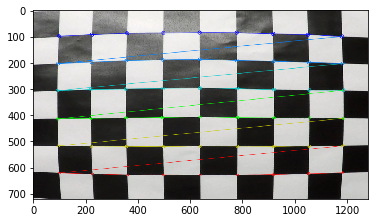

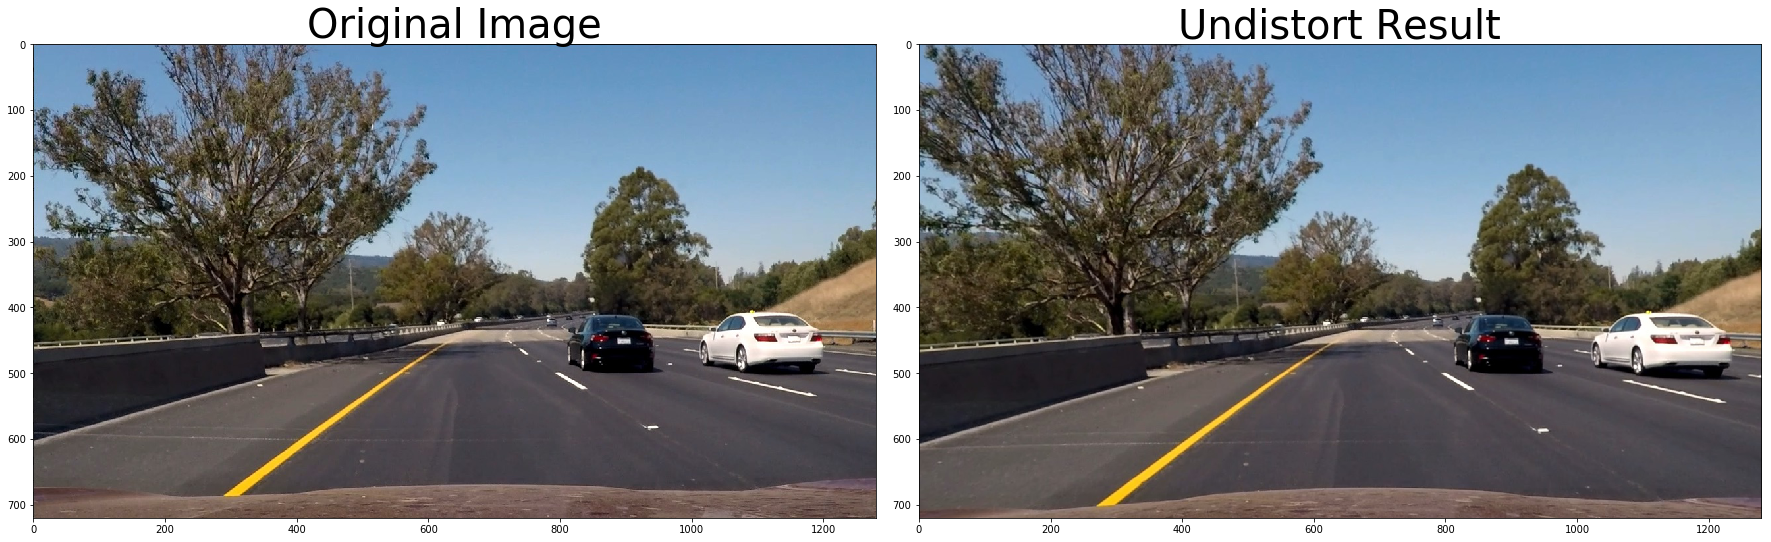

In [116]:
def undistort(img):
    folder_calibration=glob.glob("camera_cal/calibration*.jpg")
    mtx,dist,rvecs,tvecs=camera_calibration(folder_calibration,9,6)
    return cv2.undistort(img,mtx,dist,None,mtx)

#folder_calibration=glob.glob("camera_cal/calibration*.jpg")
#mtx,dist,rvecs,tvecs=camera_calibration(folder_calibration,9,6)
img_test=glob.glob("test_images/*.jpg")
img=np.random.choice(img_test)
img=mping.imread("test_images/test6.jpg")
dst=undistort(img)
#plt.imshow(img)
#plt.imshow(dst)
#plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(dst)
ax2.set_title('Undistort Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

Image process：1.x and y gradient 2.magnitude gradient 3.direction gradient 4.hls 5.perspective transform

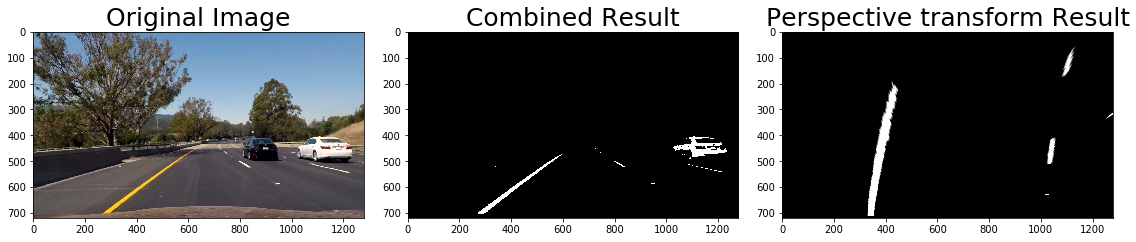

In [117]:
def gray_img(image):
    return cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)

def axis_sobel(image,orient):
    if orient=="x":
        sobel=cv2.Sobel(image,cv2.CV_64F,1,0,ksize=9)
    else:
        sobel=cv2.Sobel(image,cv2.CV_64F,0,1,ksize=9)
    return sobel
def axis_gradient(img,orient="x",thresh=(20,255)):
    gray=gray_img(img)
    if orient=="x":
        sobel=axis_sobel(gray,orient="x")
    else:
        sobel=axis_sobel(gray,orient="y")
    
    abs_sobel=np.absolute(sobel)
    scaled_sobel=np.uint8(255*abs_sobel/np.max(abs_sobel))
    s_binary=np.zeros_like(scaled_sobel)
    s_binary[(scaled_sobel>=thresh[0])&(scaled_sobel<=thresh[1])]=1
    return s_binary

def mag_gradient(img,thresh=(30,100)):
    gray=gray_img(img)
    sobelx=axis_sobel(gray,orient="x")
    sobely=axis_sobel(gray,orient="y")
    gra_mag=np.sqrt(sobelx**2+sobely**2)
    scaled_gra=np.uint8(255*gra_mag/np.max(gra_mag))
    mag_binary=np.zeros_like(scaled_gra)
    mag_binary[(scaled_gra>=thresh[0])&(scaled_gra<=thresh[1])]=1
    return mag_binary

def dir_gradient(img,thresh=(0,np.pi/4)):
    gray=gray_img(img)
    sobelx=axis_sobel(gray,orient="x")
    sobely=axis_sobel(gray,orient="y")
    angle=np.arctan2(np.absolute(sobely),np.absolute(sobelx))
    dir_binary=np.zeros_like(angle)
    dir_binary[(angle>=thresh[0])&(angle<=thresh[1])]=1
    return dir_binary

def hls_select_l(img,thresh=(220,255)):
    hls=cv2.cvtColor(img,cv2.COLOR_RGB2HLS)
    l=hls[:,:,1]
    l=l*(255/np.max(l))
    hls_binary=np.zeros_like(l)
    hls_binary[(l>thresh[0])&(l<=thresh[1])]=1
    return hls_binary

def lab_select_b(img,thresh=(195,255)):
    lab=cv2.cvtColor(img,cv2.COLOR_RGB2Lab)
    b_channel=lab[:,:,2]
    #don't normalize if there are no yellows in the image
    if np.max(b_channel)>100:
        b_channel=b_channel*(255/np.max(b_channel))
    lab_binary=np.zeros_like(b_channel)
    lab_binary[(b_channel>thresh[0])&(b_channel<=thresh[1])]=1
    return lab_binary

def combined_binary(img):
    gradx=axis_gradient(img,orient="x")
    #grady=axis_gradient(img,orient="y")
    #mag_binary=mag_gradient(img,thresh=(30,255))
    #dir_binary=dir_gradient(img,thresh=(0,np.pi/2))
    s_binary=s_select(img)
    hls_binary=hls_select_l(img)
    lab_binary=lab_select_b(img)
    combined=np.zeros_like(lab_binary)
    #combined[((gradx==1)&(grady==1))|(mag_binary==1)&(dir_binary==1)|(hls_binary==1)]=1
    combined[(gradx==1)&((hls_binary==1)|(lab_binary==1))]=1
    combined[(hls_binary==1)|(lab_binary==1)]=1
    return combined
    
def s_select(img,thresh=(180,255)):
    hls=cv2.cvtColor(img,cv2.COLOR_RGB2HLS)
    s=hls[:,:,2]
    s=s*(255/np.max(s))
    s_binary=np.zeros_like(s)
    s_binary[(s>thresh[0])&(s<=thresh[1])]=1
    return s_binary

def r_select(img,thresh=(200,255)):
    
    r=img[:,:,0]
    r_binary=np.zeros_like(r)
    r_binary[(r>thresh[0])&(r<=thresh[1])]=1
    return r_binary


def perspective_transform(img):
    #gray=cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    #src = np.float32([[240,720],[575,470],[735,470],[1200,720]])
    #dst = np.float32([[300,720],[300,0],[1000,0],[1000,720]])
    src = np.float32([[580, 460], [700, 460], [1096, 720], [200, 720]])
    dst = np.float32([[300, 0], [950, 0], [950, 720], [300, 720]])
    M=cv2.getPerspectiveTransform(src,dst)
    img_size=(img.shape[1],img.shape[0])
    bird_view=cv2.warpPerspective(img,M,img_size,flags=cv2.INTER_LINEAR)
    return bird_view

#img=mping.imread("test_images/straight_lines2.jpg")
combined_img=combined_binary(dst)
bir_view_img=perspective_transform(combined_img)
f, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(15, 6))
f.tight_layout()
ax1.imshow(dst)
ax1.set_title('Original Image', fontsize=25)

ax3.imshow(bir_view_img,cmap="gray")
ax3.set_title('Perspective transform Result', fontsize=25)

ax2.imshow(combined_img,cmap='gray')
ax2.set_title('Combined Result', fontsize=25)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
                  

    
                  

    

Locate the Lane Lines:1.histogram 2.Sliding window 3.use a polygon search from prior

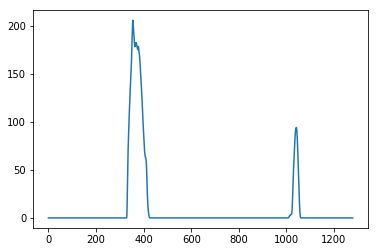

In [118]:
def hist(img):
    bottem_half=img[img.shape[0]//2:,:]
    histogram=np.sum(bottem_half,axis=0)
    return histogram

histogram=hist(bir_view_img)
plt.plot(histogram)

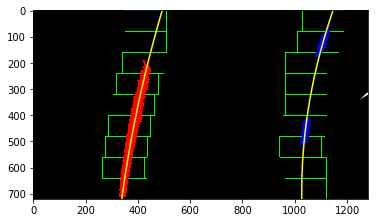

In [119]:
def fine_lane_pixels(waraped_img):
    histogram=np.sum(waraped_img[waraped_img.shape[0]//2:,:],axis=0)
    #out_img=np.dstack((waraped_img,waraped_img,waraped_img))
    out_img=(np.dstack((waraped_img,waraped_img,waraped_img))*255).astype('uint8')
    #the midpoint of the image
    midpoint=np.int(histogram.shape[0]//2)
    #the starting points of the left and right line
    leftx_base=np.argmax(histogram[:midpoint])
    rightx_base=np.argmax(histogram[midpoint:])+midpoint
    #the parameters of sliding windows
    nwindows=9
    margin=80
    minpix=50
    window_height=np.int(out_img.shape[0]//nwindows)
    
    #find the x and y positions of all nonzero pixels
    nonzero=waraped_img.nonzero()
    nonzeroy=np.array(nonzero[0])
    nonzerox=np.array(nonzero[1])
    
    #current postions
    leftx_current=leftx_base
    rightx_current=rightx_base
    
    #receive left and right pixel indices
    left_lane_inds=[]
    right_lane_inds=[]
    
    #create windows one by one
    for window in range(nwindows):
        #window boundaries
        win_y_low=waraped_img.shape[0]-(window+1)*window_height
        win_y_high=waraped_img.shape[0]-window*window_height
        win_xleft_low=leftx_current-margin
        win_xleft_high=leftx_current+margin
        win_xright_low=rightx_current-margin
        win_xright_high=rightx_current+margin
        
        #draw the windows
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0),2)
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0),2)
        
        #fined all nonzero pixels within the window
        good_left_inds=((nonzeroy>=win_y_low)&(nonzeroy<win_y_high)&(nonzerox>=win_xleft_low)&(nonzerox<win_xleft_high)).nonzero()[0]
        good_right_inds=((nonzeroy>=win_y_low)&(nonzeroy<win_y_high)&(nonzerox>=win_xright_low)&(nonzerox<win_xright_high)).nonzero()[0]
        
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        #next window
        if len(good_left_inds)>minpix:
            leftx_current=np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds)>minpix:    
            rightx_current=np.int(np.mean(nonzerox[good_right_inds]))
            
    #concatenate the induices to array
    try:
        left_lane_inds=np.concatenate(left_lane_inds)
        right_lane_inds=np.concatenate(right_lane_inds)
    except ValueError:
        pass
    
    #left and  right line positions
    leftx=nonzerox[left_lane_inds]
    lefty=nonzeroy[left_lane_inds]
    rightx=nonzerox[right_lane_inds]
    righty=nonzeroy[right_lane_inds]
    
    return leftx,lefty,rightx,righty,out_img

def fit_polynomial(waraped_img,demo):
    #positions
    leftx,lefty,rightx,righty,out_img=fine_lane_pixels(waraped_img)
    
    #cofficents
    left_fit=np.polyfit(lefty,leftx,2)
    right_fit=np.polyfit(righty,rightx,2)
    ploty=np.linspace(0,waraped_img.shape[0],waraped_img.shape[0])

    try:
        left_fitx=left_fit[0]*ploty**2+left_fit[1]*ploty+left_fit[2]
        right_fitx=right_fit[0]*ploty**2+right_fit[1]*ploty+right_fit[2]
    except TypeError:
        print("The function failed to fit a line")
        left_fitx=ploty**2+ploty
        right_fitx=ploty**2+ploty
    #Visualization    
    out_img[lefty,leftx]=[255,0,0]
    out_img[righty,rightx]=[0,0,255]
    
    #plots lane lines
    if demo==1:
        plt.plot(left_fitx,ploty,color='yellow')
        plt.plot(right_fitx,ploty,color='yellow')
       
    return out_img,left_fitx,right_fitx,ploty
    
out_img,left_fitx,right_fitx,ploty=fit_polynomial(bir_view_img,demo=1)
#leftx,lefty,rightx,righty,out_img=fine_lane_pixels(bir_view_img)
#out_img=np.dstack((bir_view_img,bir_view_img,bir_view_img))
plt.imshow(out_img)

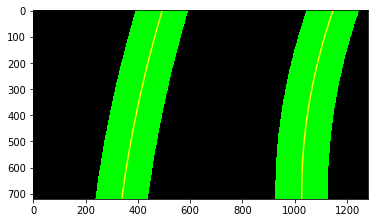

In [120]:
def search_around_poly(waraped_img):
    out_img,left_fitx,right_fitx,ploty=fit_polynomial(waraped_img,demo=1)
    #out_img=(np.dstack((out_img,out_img,out_img))*255).astype('uint8')
    window_img=np.zeros_like(out_img)
    
    margin=100
    left_line_window1=np.array([np.transpose(np.vstack([left_fitx-margin,ploty]))])
    left_line_window2=np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin,ploty])))])
    left_line_pts=np.hstack((left_line_window1,left_line_window2))
    
    right_line_window1=np.array([np.transpose(np.vstack([right_fitx-margin,ploty]))])
    right_line_window2=np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin,ploty])))])
    right_line_pts=np.hstack((right_line_window1,right_line_window2))
    
    cv2.fillPoly(window_img,np.int_([left_line_pts]),(0,255,0))
    cv2.fillPoly(window_img,np.int_([right_line_pts]),(0,255,0))
    
    #leftx,lefty,rightx,righty,out2_img=fine_lane_pixels(waraped_img)
    #window_img[lefty,leftx]=[255,0,0]
    #window_img[righty,rightx]=[0,0,255]
    
    #result=cv2.addWeighted(out_img,1,window_img,0.3,1)
    
    return window_img



result=search_around_poly(bir_view_img)
plt.imshow(result)
    

Measuring Curvature

In [52]:
def curvature(img):
    out_img,left_fitx,right_fitx,ploty=fit_polynomial(img,demo=0)
    #x and from pixels space to meters
    xm_per_pixel=3.7/720
    ym_per_pixel=30/700
    
    y_eval=np.argmax(ploty)
    left_fit = np.polyfit(ploty, left_fitx, 2)
    right_fit = np.polyfit(ploty, right_fitx, 2)
    left_curverad=(1+(2*left_fit[0]*y_eval*ym_per_pixel+left_fit[1])**2)**1.5/np.absolute(2*left_fit[0])
    right_curverad=(1+(2*right_fit[0]*y_eval*ym_per_pixel+right_fit[1])**2)**1.5/np.absolute(2*right_fit[0])
    radious=(left_curverad+right_curverad)/2*0.001
    
    return radious

    

The position of the vehicle with respect to center

In [53]:
def position_from_center(img):
    out_img,left_fitx,right_fitx,ploty=fit_polynomial(img,demo=0)
    y_eval=np.argmax(ploty)
    left_fit = np.polyfit(ploty, left_fitx, 2)
    right_fit = np.polyfit(ploty, right_fitx, 2)
    x_left_pix=left_fit[0]*y_eval**2+left_fit[1]*y_eval+left_fit[2]
    x_right_pix=right_fit[0]*y_eval**2+right_fit[1]*y_eval+right_fit[2]
    xm_per_pixel=3.7/720
    #3.7/2 the midpoint od the road
    pos_from_center=np.absolute(x_right_pix-x_left_pix)/2*xm_per_pixel-3.7/2
    
    return pos_from_center

Waraped the image from bird_view to normal

In [90]:
def bird_transform_normal(image):
    #src=np.float32([[520,480],[100,720], [1280,720],[760,480]])
    #offset=210
    img_size=(image.shape[1],image.shape[0])
    #dst=st = np.float32([[offset, 0], [offset, img_size[1]],[img_size[0] - offset, img_size[1]],[img_size[0] - offset,0]])
    #src = np.float32([[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],[((img_size[0] / 6) - 10), img_size[1]],[(img_size[0] * 5 / 6) + 60, img_size[1]],[(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
    #dst = np.float32([[(img_size[0] / 4)-80, 0],[(img_size[0] / 4)-80, img_size[1]],[(img_size[0] * 3 / 4)-120, img_size[1]],[(img_size[0] * 3 / 4)-120, 0]])
    src = np.float32([[580, 460], [700, 460], [1096, 720], [200, 720]])
    dst = np.float32([[300, 0], [950, 0], [950, 720], [300, 720]])
    Minv=cv2.getPerspectiveTransform(dst,src)
    normal=cv2.warpPerspective(image,Minv,img_size,flags=cv2.INTER_LINEAR)
    
    return normal

#normal=bird_transform_normal(result)
#plt.imshow(normal)

Visualization

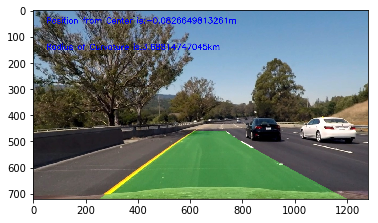

In [121]:
def visualization(undistort,bird_view):
    waraped_zero=np.zeros_like(bird_view).astype(np.uint8)
    color_waraped=np.dstack((waraped_zero,waraped_zero,waraped_zero))
    out_img,left_fitx,right_fitx,ploty=fit_polynomial(bird_view,demo=0)
    #margin=2
    left_line_window=np.array([np.transpose(np.vstack([left_fitx,ploty]))])
    right_line_window=np.array([np.flipud(np.transpose(np.vstack([right_fitx,ploty])))])
    line_pts=np.hstack((left_line_window,right_line_window))
    cv2.fillPoly(color_waraped,np.int_([line_pts]),(0,255,0))
    
    #leftx,lefty,rightx,righty,out2_img=fine_lane_pixels(bird_view)
    #color_waraped[lefty,leftx]=[255,0,0]
    #color_waraped[righty,rightx]=[0,0,255]
    
    green_img=bird_transform_normal(color_waraped)
    output_img=cv2.addWeighted(undistort,1,green_img,0.3,0)
    
    #add curvature and positin from center
    pos_from_center=position_from_center(bird_view)
    radious=curvature(bird_view)
    cv2.putText(output_img,'Position from Center is:'+str(pos_from_center)+'m',(50,50),cv2.FONT_HERSHEY_SIMPLEX,1,(0,0,255),2,cv2.LINE_AA)
    cv2.putText(output_img,'Radius of Curvature is:'+str(radious)+'km',(50,150),cv2.FONT_HERSHEY_SIMPLEX,1,(0,0,255),2,cv2.LINE_AA)
    
    return output_img

img=visualization(dst,bir_view_img)
plt.imshow(img)
    
    


Test functions

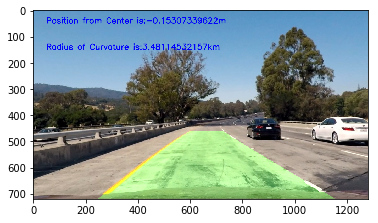

In [92]:
def correction_cofficient(folder,nx,ny):
    objpoints=[]
    imgpoints=[]
    obj=np.zeros((nx*ny,3),np.float32)
    obj[:,:2]=np.mgrid[0:nx,0:ny].T.reshape(-1,2)
    #folder=glob.glob("camera_cal/calibration*.jpg")
    #nx=9
    #ny=6
    for image in folder:
        img=mping.imread(image)
        gray=cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
        ret,corners=cv2.findChessboardCorners(gray,(nx,ny),None)
        if ret==True:
            imgpoints.append(corners)
            objpoints.append(obj)
            img=cv2.drawChessboardCorners(img,(nx,ny),corners,ret)
            plt.imshow(img)
    
    ret,mtx,dist,rvecs,tvecs=cv2.calibrateCamera(objpoints,imgpoints,gray.shape[::-1],None,None)         
    return mtx,dist,rvecs,tvecs

mtx,dist,rvecs,tvecs=correction_cofficient(glob.glob("camera_cal/calibration*.jpg"),9,6)

def sliding_window(img):
    #undistort_img=undistort(img)
    undistort_img=cv2.undistort(img,mtx,dist,None,mtx)
    combined_img=combined_binary(undistort_img)
    bird_view_img=perspective_transform(combined_img)
    output_img=visualization(undistort_img,bird_view_img)
    
    return  output_img
img=mping.imread("test_images/test1.jpg")
result=sliding_window(img)
plt.imshow(result)

Test on video

In [93]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
def process_image(image):
    result=sliding_window(image)
    return result
vedio_output = 'P2/output_videos/project_video.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) 
%time white_clip.write_videofile(vedio_output, audio=False)

[MoviePy] >>>> Building video P2/output_videos/project_video.mp4
[MoviePy] Writing video P2/output_videos/project_video.mp4


100%|█████████▉| 1260/1261 [08:18<00:00,  2.56it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: P2/output_videos/project_video.mp4 

CPU times: user 6min 5s, sys: 3.28 s, total: 6min 8s
Wall time: 8min 21s


In [94]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(vedio_output))